# Hyperparameter tuning for Hidden Markov Models#

This is the Hyperparameter tuning notebook for the Hidden Markov Model (HMM) for trial data  "HMM for trial data". To get general information about the HMM, loading the core code of the Linderman Lab, the helper functions and the file/directory structure, please read the first few blocks of that notebook "HMM for trial data". 

The Hidden Markov Model (HMM) is an unsupervised machine learning method. Unsupervised machine learning methods need hyperparameters to start with. For example for the method K-means clustering one has to know how many clusters should be used. For HMMs one need to know how many hidden states there are. But this is exactly what in most applications is not known at the start of the analysis. There are two methods to solve this problem: 

- trial and error (just try) or

- using a metric (elbow method).

In K-means clustering studies the elbow method is used and the metric is the within cluster sum of squared errors (distortion, inertia, minimize), see [here](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/) or [here](https://realpython.com/k-means-clustering-python/). In HMM often just the maximum likelihood is taken as a metric but this metric proved not to be helpful for the data for mouse 5, 6, 7 and 9 collected by Dr. Y. Galleros-Salas for the tactile task, see [here](https://www.sciencedirect.com/science/article/pii/S0896627320308138) and studied in the notebook "HMM for trial data". A new metric had to be defined called "even odd cross sum". The information which is digged out with the help of HMMs lies in time series. Once these series are perturbed (scrambled) the information is lost. Random cross validation is therefore not an option. But to take out time steps in a regular manner is allowed. Because the HMM is a generative model, one can sample from it which allows to define a model (with a known number of hidden states) and generate "artificial" data with that model (simulation). On this data the metric for finding the number of hidden states can be testet, because the truth is known. It has shown that to calculate the likelihood separatley for even and odd time steps crossed and add the results together is a reliable metric for estimating the number of hidden states. Crossed means that the model is fitted, e.g., to the even time steps and the likelihood for odd time steps is calculated with that model (and the otherway around). Independently the same result was found by two french mathematicians [here](https://hal.inria.fr/inria-00193098/document). The hyperparameter tuning is done on averaged data, see below. The number of frames varies, depending on the mice and sessions taken, it is between 160 and 240. The splitting into even and odd time steps reduces the number of time steps. To fit the model with the core code, see [here](https://github.com/lindermanlab/ssm), time steps in the order of 100 (half of the datas) or less can occasionally produce NAN's (in the function "multivariate_normal_logpdf",  "batch_mahalanobis" of the core code) such that the code stops. In order to increase the number of time steps after dividing by 2, the even, respectivelly the odd elements in the array "obs_even/obs_odd" are repeated such that the code runs smoothly and even in a loop with many cycles no NAN's (and stopping) should be generated. 

To define a model one should also take in account the occram's razor principle which implies that a model should be as simple as possible. The less free parameters the better. In HMM the parameters to fit scale roughly quadratically with the number of hidden states because the transition matrix holds number of hidden states squared (- number of states, because the the weights/probabilities add up to 1). The emission matrices and the initalisation matrix scale linearly with the state number. There are metrics that take this penalization of complicated models described by a lot of parameters into account. These penalised likelihood criteria are: Akaike criterium (AIC), integrated likelihood criterion (BIC), Integrated Completed Likelihood (ICL) and Penalised Marginal Likelihood (PML), see [here](https://hal.inria.fr/inria-00193098/document). They differ in which kind of likelihood they use and how the parameters are penalized. The AIC does not take into account the length of the time series, where as the others do. It was found that the AIC, based on the "even odd cross sum"  leads to the good results which are essentially the same as with the BIC because in averaged data only time series with the same number of frames are considered.  

These two metrics ("even odd cross sum" and AIC) are used in this notebook to find a good *guess* for the number of hidden states for the HMM. Most often both metrics delivers the same number of hidden states or the result differs just about one or two. As mentioned above hyperparameter tuning is more an art or a "informed guess". If you look at the plots "log likelihood vs number of states" the differences between the log likelihoods of two states maybe so tiny, that the human eye/brain would say, they are equal. A code looking for the maximal number will find a maximum for one number of states, despite the curve in the neighborhood of this number is almost flat. The name "elbow method" is describing exactly this fact. It is not about finding a maximum/minimum, it is more about finding the number where the curve starts to decrease/increase saliently. The code given in this notebook produces plots with the curves for "even odd cross sum", Akaike criterium and the original log likelihood against the number of states. The code also offers an automatic determination of the minmimum/maximum  but in addition offers the option to takes values defined by eye: Look for the maximum/minimum, but also take into accout the differences between two numbers of states ("gradient"). There are excpected differences in different runs because of the randomly choosen initialisation values of the fitted parameters. Therefore run some dozens trials and make some simple statistics. It will soon be clear in which range a good guess of the number of states will be. For the data of Dr. Galeros-Salas for mice 5,6,7 and 9 in tactile tasks this are 4 to 6 states for sorted trials. 


In the blocks 1 to 3 data from Dr. Y. Galleros-Salas are loaded, but you can also load your own data. 

If you would like to use other data, organize your data in the form of a 3 dimensional numpy array
with:

- axis = 0   --> trials
- axis = 1   --> timesteps/frames
- axis = 2   --> dimensions (ROI's)

and name this array : "data" and start with code block 4. In addition you have to define some variables like name, or trial_type for the titles of the plots and the names of the files saving them.

The data are prepared (the mean is taken over axis 0 of the array "data") in block 4. The block 5 respectively 6 preprocesses the prepared data (dimensionality reduction either with Factor Analysis (FA, block 5) or Principle Component Analysis PCA, block 6). For more information about the preprocessing step, see in the notebook "HMM for trial data". Block 7 takes some parameters for generating the plots. Block 8 calculates the metrics ("even odd cross sum", AIC and original llh) for all the desired models (numbers of states) and stores the results in a dictionary. These results can be printed in a table (block 8) or as plots (block 9). The plots can be saved in automatically generated subfolders of your working directory. For the folder structure see notebook "HMM for trial data". Block 10 allows to do simple statistics (just counting how many times a certain number of states occurs, histogram) in different runs for the same data either automatically by looking for matching minmima (AIC) and maxima (even odd cross sum) or manually by defining a list of the numbers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys

In [27]:
sys.path.append(r'C:\Users\Susanne Valavanis\PyCharmProjects\MyHMM')

from data_import import *
import data_import
from preprocessing import *
import preprocessing
from session_lists import *
import session_lists
from plots import *
import plots
from fit_and_viterbi  import *
import fit_and_viterbi
from hyperparameter import *
import hyperparameter

In [26]:
import importlib
importlib.reload(hyperparameter)

<module 'hyperparameter' from 'C:\\Users\\Susanne Valavanis\\PyCharmProjects\\MyHMM\\hyperparameter.py'>

# Preparing the list holding the sessions to be analysed#

To create the list of sessions to build the 3 dimensional data array ('data') run the following input block 1a which takes as input the Mouse name you would like to examine, the trial type, the number of time steps/frames and the delay.

1. Choose a mouse (just two key strokes, a "empty" keystroke after Mx will cause an error):
    - for Mouse 5, type: M5
    - for Mouse 6, type: M6 
    - for Mouse 7, type: M7
    - for Mouse 9, type: M9.
    

2. Choose a trial typ: Hit, CR, FA, Early, Miss or All.<br/> 
   "All" has to be taken if the the model should be fitted to all data.<br/><br/>      

3. Choose the number of frames/timesteps according to the table below.<br/><br/>

4. Choose the delay in seconds according to the above below. <br/><br/>

Block 1b allows to print the given parameters to check.

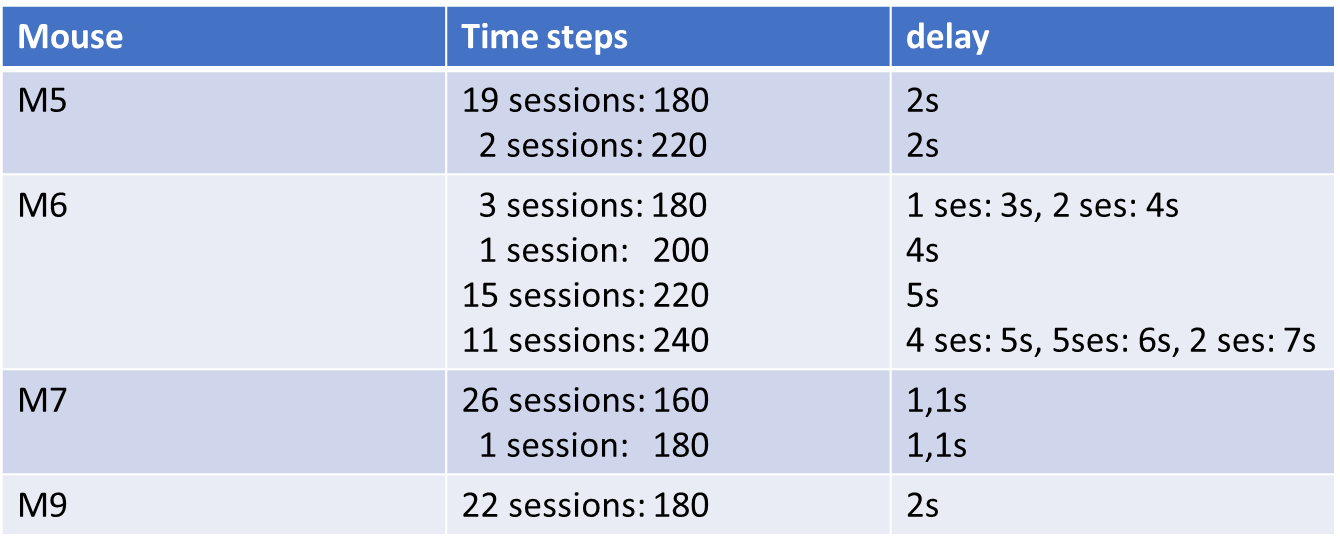

# Block 1: Input for Mouse data#


**Block 1a** gets the mouse name and the trial type. It is used for collecting the data from the H5py files. Further it gets the number of frames and delay in seconds. It is used for the titles of the plots and the names of the files storing the plots. Frames and time steps are used in this notebook as synonymes. **Block 1b** prints the input to check it (optional).

In [3]:
#Block 1a, mandatory: input (Mouse, trial type, number of frames, trial type)
name = get_and_check_mouse_name()
trial_type = get_and_check_trial_type()
frames = get_and_check_frame_number(name)
delay = get_and_check_delay_all(name,frames)

Mouse name:         M6
Trial type:         FA
Number of frames:   220
delay in seconds:   5


In [4]:
#Block 1b, optional: check the input
print_to_check(name, trial_type, frames, delay)


name      :         M6
trial_type:         FA
frames    :         220
delay     :         5.0


# Block 2: Creation of the list of sessions "lst_sessions"#

**Block 2** automatically creates the list of sessions for the mouse defined above and print it to control/to have an overview. 

In [5]:
#Block 2 creates automatically a list of sessions according to the input above
lst_sessions = get_lst_sessions(name, frames, delay, trial_type)

the list to be analysed is:

['20170927_a', '20170927_b', '20170927_c', '20171004_a', '20171005_a', '20171005_b', '20171006_b', '20171009_a', '20171009_b', '20171010_a', '20171010_b', '20171010_c', '20171011_a', '20171012_b', '20171012_c']

the length of the list is: 15


## Creation of the 3 dimensional data array ##

The function "get_data_1" creates the 3 dimensional data array "data" for the Mouse/sessions you selected above in block 1a and 2. The function reads the data from the H5py File. The path to that file has to be specified in the variable "path" in the next block (block 3, code line 3). The function scrolls through the "lst_sessions" (created in the block 2 above) containing all the sessions which will be studied. Only the trial types, specified in block 1b are taken (if you selected "All", all trials are taken). 


## Block 3: Creation of the 3 dim array "data" 

Run **block 3** for the creation of the 3 dim array "data". You get a print out to check. Maybe you have to adapt the path to your file structure. If you want to work with the same mouse sessions but just want to change the trial type, you don't have to go back to block 1/2. You just can unhash code line 8 and define the trial type you would like to analyse.

In [6]:
#Block 3, 3 dim array "data" for list of sessions with the number of frames
#adapt to your path:
path = 'C:/Users/Susanne Valavanis/JupyterNotebooks/HMM/eigene HMM/'
file, label =  get_file_and_label(name)
path = get_path(path, file)

#To change the trial type: 
#trial_type = 'All'

#function to get the 3 dimensional "data" array for the selected Mouse, sessions, trial types: 
data = get_data_1(lst_sessions, path, label, trial_type)
nice_print(data, trial_type)

complete path to the original H5py datas:

C:/Users/Susanne Valavanis/JupyterNotebooks/HMM/eigene HMM/Yasir data mouse 6/mou_6.h5


shape/dimensions of the data array:   (51, 220, 27)
Number of FA Trials:                  51
Number of time steps (frames):        220
Number of dimensions:                 27


# Block 4: Data preparation, average#

In block 4a the average over the axis 0 of the array "data" is taken. If the argument "prnt" is True, the shape of the returned 2 dimensional array "obs_aver" is printed. Block 4b plots/(saves the plot) the result (optional). If you want to save the plot:

save_figure = True, otherwise:<br/>
save_figure = False.

To avoid overwriting if you run a plot for exact the same parameters at the same day: change the number of runs.

In [7]:
#Block 4a, mandatory 
obs_aver = mean_data(data, prnt = True)

averaged:
shape of the "obs_aver" array:             (220, 27)
number of time steps:                      220
number of dimensions:                      27



In [ ]:
#Block 4b, optional: plot/save of the averaged data. 
save_figure = True
fig = plot_data_1(obs_aver, name, trial_type, frames, delay, save_figure, file, title='averaged', run=0 )

# Block 5: Preprocessing with FA

Dimensionality reduction is very common, but not mathematically necessary, if one is working with HMMs, see "HMM for trial data" and literature given there. One method for dimensionality reduction is Factor Analysing which is a generative model. The observations are a linear combination of the factors. For the reconstruction of the observations without a large loss of information typically not all the factors are needed, if the data are redundand (which is the case here). Therefore this method can be used to reduce the dimensions, because with only a few factors, the observations can be generated without a loss of information that matters. **Block 5a** does the necessary calculations with the help of the Factor Analysing package (which maybe have to be imported using the pip procedure). You have to choose the eigenvalue limit "eigenval_limit", the recommended/default value is 1.0. You can change this value. This can be compared to the explained variance in PCA. Factors with eigenvalues smaller then 1.0 do not contribute much information and could be ignored. The number of the factors taken is the new, reduced number of dimensions. The result is a 2d array called "obs_transformed_FA" with the shape (number of frames, number of factors). **Block 5b** plots/(saves the plot) the result (optional). Comments for plotting, see above.

In [8]:
#Block 5a: preprocessing with FA on averaged data

#choose eigenvalue limit:
eigenval_limit = 1.0

num_FA_dim = find_number_of_Factors_1(eigenval_limit, data.shape[2], obs_aver, kind = 0, prnt = True)

#function to do the dimensionality reduction from dimensions to num_FA_dim and store the result in "obs_transfomed_FA"
obs_transformed_FA = factors(num_FA_dim, obs_aver, kind = 0, prnt = True)

averaged:
Number of Factors:                            2
shape of the "obs_transformed_FA" array:      (220, 2)
number of time steps:                         220
number of dimensions:                         2



In [ ]:
#Block 5b, optional: plot of the averaged with FA dimensionality reduced data. 
save_figure = True
fig = plot_data_FA(obs_transformed_FA, name, trial_type, frames, delay, save_figure, file, title='averaged', run=0 )

# Block 6: Preprocessing with Principle Component Analysis (PCA)

With PCA one can project the observations onto the first few principle components. The principle components are a weigthed linear combination of the observations. Again as in the case of FA not all components are typically necessary to explain the variance in the data, therefore this method is used for dimensionality reduction. For further information, see "HMM for trial data". With the variable "tot_expl_variance" you can regulate how many compoments should be taken (the dimensionalty), code line 4 of **block 6a**, the default value is 0.98. If you would like to compare the results you found using the FA method, you have to adjust the "tot_expl_variance" such that the number of components are equal with the number of factors (you could of course also change the "eigenval_limit" for the FA calculations). The result is a 2d array called "obs_transformed_PCA" with the shape (number of frames, number of components). 

**Block 6b** plots/(saves the plot) the individual and cumulative explained variance for averaged data, optional. Remarks about plotting, see block 4.

**Block 6c** mandatory, projects the data on the main components using the sklearn package.

**Block 6d** plots/(saves the plot) the transformed data array, optional. Remarks about plotting, see block 4.

In [9]:
#block 6a: mandatory for dimensionality reduction with PCA for averaged data

#explained variance: 
tot_expl_variance = 0.98

corr_mat = corr_matrix(obs_aver, kind = 0, prnt = True)
eigen_vals, eigen_vecs = eigen_sorted(corr_mat, kind = 0, prnt = True)
n_components = number_of_main_components(tot_expl_variance, obs_aver, kind = 0, prnt = True)

averaged:
shape of the correlation matrix of the "obs_aver" array:                   (27, 27)
sorted Eigenvalues for averaged "obs_aver":
 [2.22181989e+01 3.55205001e+00 7.33610908e-01 2.14795523e-01
 9.67960682e-02 5.89748447e-02 4.04774427e-02 3.35481618e-02
 1.29082411e-02 1.04403786e-02 8.67422883e-03 4.71616844e-03
 4.25029157e-03 2.37354250e-03 1.72099117e-03 1.50816256e-03
 1.38446478e-03 7.93409658e-04 6.79089892e-04 5.16658985e-04
 4.14360247e-04 3.24731944e-04 2.52173232e-04 2.14774411e-04
 1.68581537e-04 1.15584639e-04 9.23294072e-05]
number of components to get the total explained variance, obs_aver:        2



In [ ]:
#block 6b: optional, plot of the individual and cumulative explained variance for averaged data
save_figure = True
fig = plot_explained_variance(tot_expl_variance, obs_aver, trial_type, name, save_figure, file, title='averaged', run=0)

In [10]:
#block 6c:  mandatory (projection), if you want to do preprocessing for averaged data with PCA. 
obs_transformed_PCA = pca(n_components, obs_aver, kind=0, prnt=True)


shape of the "obs_transformed_PCA" array:      (220, 2)
number of time steps:                          220
number of dimensions:                          2


In [ ]:
#block 6d: optional: plot of the PCA transformed averaged data. Only for data for the viterbi algorithm (defined in 
#block 1b and 1c). 
save_figure = False
fig = plot_data_PCA(obs_transformed_PCA, name, trial_type, frames,  delay, save_figure, file, title='averaged', run=0)

# Block 7: inputs

In **block 7** you have to define some input parameters:

- The maximum number of hidden states you would like to use to define a model. For Dr. Y. Galleros-Salas's data to explore the range from 2 to 14 is appropriate. Check if you see the "elbow" in the plot. <br> <br>
- The number of loops you would like go through. Each loop cycle produces a dictionary with keys: the number of hidden states and the values: log likelihood of the "even_odd_cross_sum"  the AIC and the "normal" likelihood.<br><br> 
- The number of iterations in the fitting procedure (usually 50 to 70 are enough for averaged data for convergence).<br><br> 
- The emission model which should be used in the fitting procedure. It can be "gaussian" or "autoregressive". For more information, see "HMM for trial data". The core code allows much more emission models. If you would like to use one of those, e.g. "categorical", have a look [here](https://github.com/lindermanlab/ssm) (under ssm/hmm.py, code line 85 to 105) and unhash/define the corresponding variable in block 8, line 8. 

In [19]:
# block 7: input
max_num_states, num_loops_statistics, N_iters, e_model = get_input_parameters()

Maximum number of hidden states:         14
Number of loops:                         40
Number of iterations in the fit:         70
Emission model:                          autoregressive


# Block 8:  Loop over number of states#

**Block 8** calculates the "even_odd_cross_sum" (the sum of the log likelihood (llh)) for the observations with even time steps, doubled to avoid NAN's, calculated with the model fitted to the observations with odd time steps, doubled, and the log likelihood calculated the other way around), the AIC based on the ""even_odd_cross_sum" (to take into account the number of parameters to be fitted) and the "normal" log likelihood (llh) (the probability of the observations under the model). All llh values are normalized and calculated for each model (for each number of hidden states from 2 up to the choosen maximum number of hidden states).

Depending on how many loops (number of loops, above) you have selected, this procedure is repeated. The results are stored in a dictionary for each loop cycle and the created dictionaries are appended to the list "lst_dicts". Each loop cycle will produce a print of the calculated numbers. If you don't like to have this print out (which can be long for a large number of loop cycles), change the variable "verbose" to False. In this case only the loop cycle numbers are printed.

You have to define which data is used for the calculations, please unhash the matching variable: either "obs_transformed_FA" for FA preprossed data, "obs_transformed_PCA" for data preprocessing with PCA or "obs_aver" if you did not a dimensionality reduction step. The variable "kind" is used for generating the matching legends for the plots and their file names.

In [20]:
#Block 8: loop over number of states (inner loop), loop for statistics (outerloop)

#obs, kind  = obs_aver, 'none'
obs, kind = obs_transformed_FA, 'FA'
#obs, kind = obs_transformed_PCA, 'PCA'

#definition of an emission model, which is not "gaussian" or "autoregressive"
#e_model = " categorical"

lst_dicts, lst_table = loop_over_states_and_statistics(max_num_states, num_loops_statistics, N_iters, e_model, obs,
                                                       verbose = False)



loop 0:

loop 1:

loop 2:

loop 3:

loop 4:

loop 5:

loop 6:

loop 7:

loop 8:

loop 9:

loop 10:

loop 11:

loop 12:

loop 13:

loop 14:

loop 15:

loop 16:

loop 17:

loop 18:

loop 19:

loop 20:

loop 21:

loop 22:

loop 23:

loop 24:

loop 25:

loop 26:

loop 27:

loop 28:

loop 29:

loop 30:

loop 31:

loop 32:

loop 33:

loop 34:

loop 35:

loop 36:

loop 37:

loop 38:

loop 39:


# Block 9: plots of the curves log likelihoods vs number of states

In **block 9a** the results generated in block 8 are plotted. Depending on the number of loop cycles choosen in the block 8, the number of plots can be large. **Block 9b** offers the possibility to plot/save just a selected range of examples in and **block 9c** you can choose single examples.

If save_figure = True:<br>
the plots are safed individually in the automatically created subfolder of the current working directory "Mx plots hyperparameter" x for 5,6,7 and 9 in all three cases.

In [ ]:
#Block 9a: plot and save the figures for all loop cylces

save_figure = True

fig = plots_of_eollh_llh_AIC_vs_statenumbers(lst_table, max_num_states, e_model, kind, obs, save_figure, name, 
                                             trial_type, file, run=0)

In [ ]:
#Block 9b: reduced number of plots in a range of loop cycles with a starting point "start" and an end point "end".

save_figure = True
#select the starting and ending loop cycle
start = 1
end = 3

fig = plots_of_eollh_llh_AIC_vs_statenumbers_1(start, end, lst_table, max_num_states, e_model, kind, obs, save_figure,
                                             name, trial_type, file, run=0)

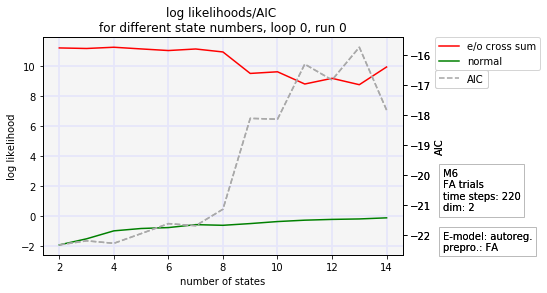

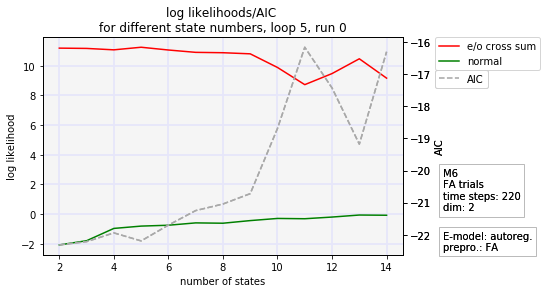

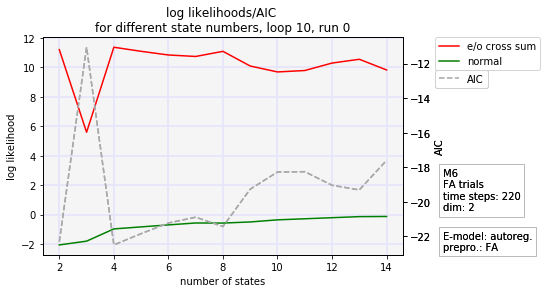

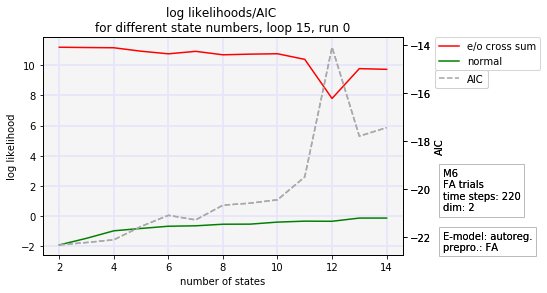

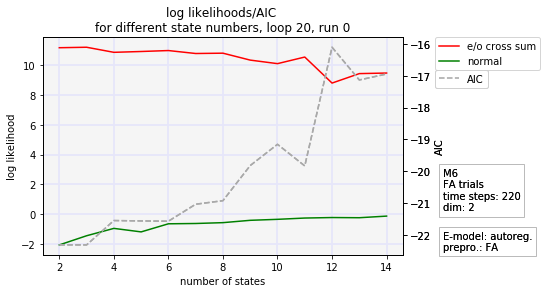

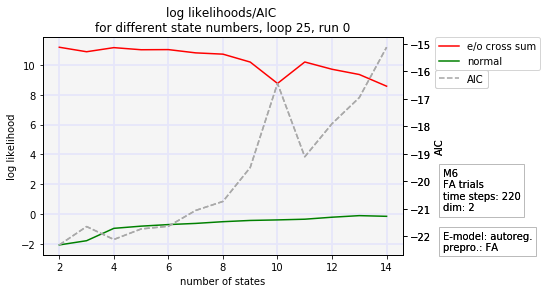

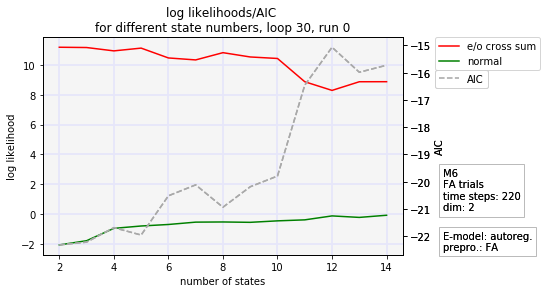

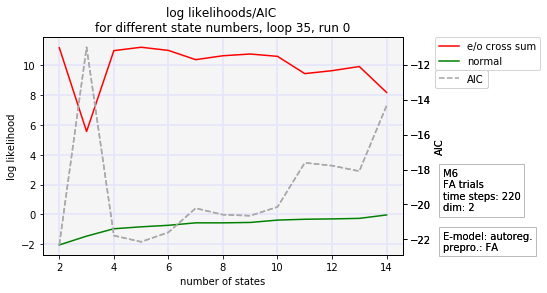

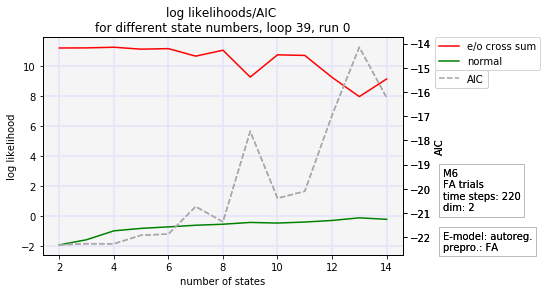

In [21]:
#Block 9c: reduced number of plots for selected single loop cycles 

save_figure = True
#select the loop cycles, used as indices in the lst_table:
lst_loops = [0,5,10,15,20,25,30,35,39]

fig = plots_of_eollh_llh_AIC_vs_statenumbers_2(lst_loops, lst_table, max_num_states, e_model, kind, obs, save_figure,
                                               name, trial_type, file, run = 0)

# Block 10: Statistics for the number of states

In a very sophisticated manner one could train a convolutional network to find the best number of states from the plots. But this is using a sledgehammer for cracking a nut. Because it is just to generate an "informed" guess for the most probable numbers of states and it would need many, many examples. In the plot below, Figure 1, it is more likely that the number of states is 5,6 or 7 but not so likely to be 2 or 12. Note the difference of the e/o cross sum and the AIC values for the number of states 9. The e/o cross sum for number of states: 9 is almost a maximum value, but the AIC is not the minimum.

**Block 10a** offers an automatic determination of the most probable number of states based on the maximum of the even_odd_cross_sum log likelihood and the minimum of the Akaike criterion (based on this log likelihood). If both the minimum and the maximum occure for the same number of states this number is taken. In the example below (Figure 1) it would be: 5. If the minimum and maximum do not occure for the same number of states, the result is rejected for the bar plot, but it is printed: the probable number of states lies somewhere between the minimum and the maximum, so you can have a look on the plots where the min!=max and decide yourself. Block 10c allows to define the input list manually. You can copy the min=max list and add your manually picked numbers. 

**Block 10b** plots the result: for the analysed trial type a bar plot with the number of occurances of the found number of states (only numbers where min=max are taken, so the number of runs and the length of the list "lst_input_statistics" can differ). 

But sometimes just to look at the minimum/maximum can be missleading, because differences can be very, very small (log numbers). Therefore it is also possible just to look at the curves (elbow method, finding the number where the curve starts to decrease/increase saliently) and judge by eye which are the best guesses and fill the numbers in the appropriate list in **block 10c**. An example is shown in the plot below, Figure 2. In this example the automatic determination will give the number of states: 4. But the curve is very flat up to number of states: 6. According to the "elbow" the number of states: 6 would be more likely. Once you have a sufficient quantity of such numbers of states for each trial type filled into the corresponding lists, the code produces bar plots for the occurance of number of states for each trial type seperately (**block 10d**). If you did not analyse the data for a specific trial type, please fill the list with *one* zero, e.g. Miss = np.array(([0])).


If you want to save the plot please set:<br> save_figure = True, otherwise:<br> save_figure = False. <br>The plot will be stored in the automatically generated subdirectory of the current working directory "Mx plots hyperparameter", x = 5,6,7 and 9. 

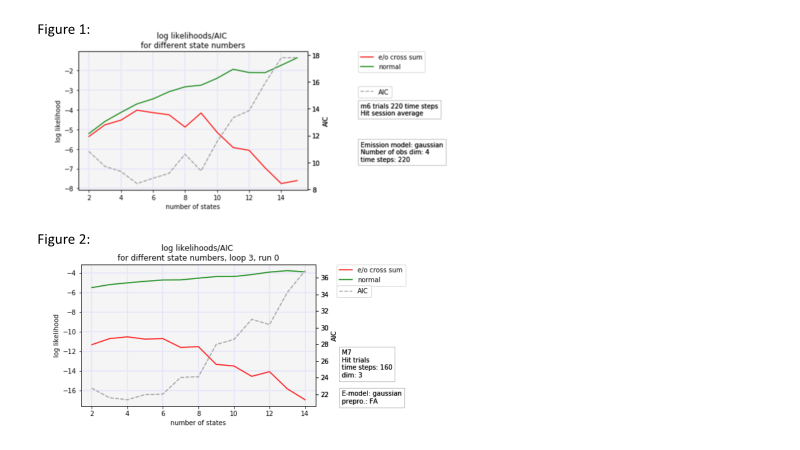

In [22]:
#Block 10a: statistics for the automatic defined most probable number of states, based on the matching maximum of the
#even_odd_cross_sum log likelihood and the minimum of the even_odd_cross_sum based Akaike criterion
#only values are taken where min=max, if min!=max the run is rejected for the input list

lst_input_statistics, arr, mini, maxi = find_number_of_states_loop1(lst_dicts, num_loops_statistics, trial_type)

for each run for statistics:
probable number of hidden states are in the range of: 2 to 4
probable number of hidden states is: 4
probable number of hidden states is: 4
probable number of hidden states are in the range of: 2 to 5
probable number of hidden states is: 3
probable number of hidden states are in the range of: 2 to 5
probable number of hidden states is: 4
probable number of hidden states is: 3
probable number of hidden states are in the range of: 2 to 5
probable number of hidden states is: 4
probable number of hidden states is: 4
probable number of hidden states is: 3
probable number of hidden states are in the range of: 2 to 6
probable number of hidden states is: 3
probable number of hidden states is: 4
probable number of hidden states is: 2
probable number of hidden states is: 4
probable number of hidden states is: 4
probable number of hidden states are in the range of: 2 to 5
probable number of hidden states are in the range of: 2 to 5
probable number of hidden states is: 

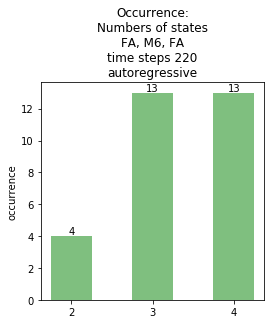

In [28]:
#Block 10b:  function to plot the results as a bar plot for the analysed trial type based on the list defined 
#in block 10a.

save_figure = True

fig = bar_plot_single(mini, maxi, arr, trial_type, name, kind, e_model, obs, save_figure, file, run=0)

In [30]:
#Block 10c: list to fill with the observed number of states, if no numbers exist for a specific trial type, just fill in
#one zero (only one zero).


Hit = np.array(([5,4,5,5,6,4,4,5,4,3,4,4,6,5,5,4,4,5,5,4,4,4,4,4,4,4,3,4,5,5,3,4,4,5,4]))

CR = np.array(([7,6,7,5,7,7,4,5,7,5,6,6,6,5,6,6,6,5,5,4,4,4,5,6,6,6,5,6,5,4,6,6,5,4,4,6,5,5,5]))

FA = np.array(([6,5,7,6,6,6,6,6,6,11,10,6,7,6,6,6,7,7,4,4,6,4,6,5,6,4,5,6,5,5,4,5,6,5,5,4,6,3,4]))

Early = np.array(([5,6,5,7,6,6,4,6,5,5,4,4,5,8,5,7,7,6,6,8,5,7,4,4,5,4,5,5,5,6,6,6,5,4,4,7]))

Miss = np.array(([0]))

All = np.array(([6,6,5,5,3,6,6,5,5,3,6,6,5,5,3,6,6,6,7,4,5,5,4,6,6,]))

mini, maxi = get_mini_maxi_manual_case(Hit, CR, FA, Early, Miss, All)

the minimum number of states over all trial types is: 3
the maximum number of states over all trial types is: 11


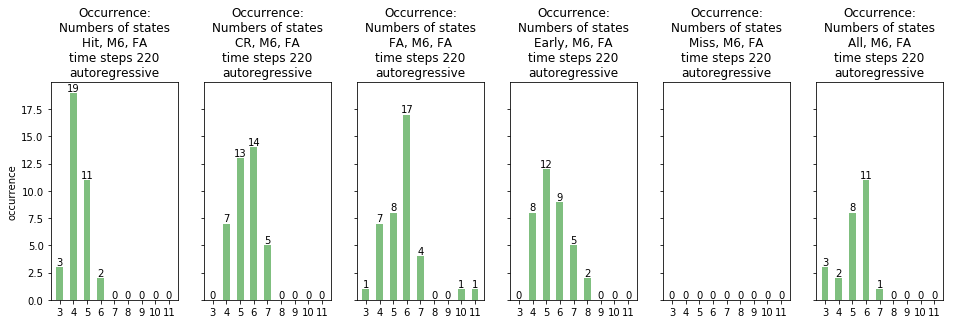

In [31]:
#Block 10d:  function to plot the results as a bar plot for the analysed trial types based on the lists defined 
#in block 10c.

save_figure = True

#function to produce the bar plot
fig = bar_plot(mini, maxi, Hit, CR, FA, Early, Miss, All, name, kind, e_model, obs, save_figure, file, run=0)